# Problem 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from datetime import datetime
from mlxtend.evaluate import bias_variance_decomp

In [2]:
# Converts date of form "YYYYMM" to a datetype
def dateConverter(date):
    datestring = str(date)
    year = datestring[0:4]
    month = datestring[4:6]
    return datetime.strptime((year + "-" + month + "-01"), '%Y-%m-%d').date()

In [3]:
df = pd.read_csv("30_Industry_Portfolios.csv")

# Convert date of form "YYYYMM" to a datetype
df['YYYYMM']=df['YYYYMM'].apply(dateConverter)
df = df.set_index("YYYYMM")
# Lag returns
for col in df.columns:
    df[col+"_T-1"] = df[col].shift(1)
# Remove first row (get rid of NaNs)
df = df.drop(index=df.index[0])

train_set = round(len(df.iloc[:,30:])*.75)

### Analysis on returns for the beer industry

I start my analysis by first indentifying a reasonable alpha for lasso regression. I begin with this because I would like to compare linear regression and lasso regression by plotting the actual vs predicted returns using both in one plot.

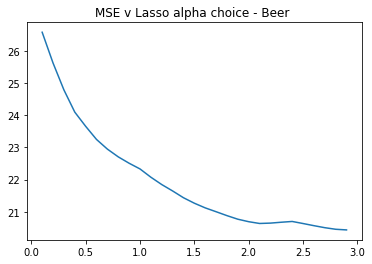

In [4]:
# Look for a good alpha to use for lasso regression
# for beer returns

alphas = np.arange(.1, 3, .1)
MSE_lasso = list()

# Create train and test subsets of the data (75%/25%)
Xa_train = (df.values[:train_set,30:])
Ya_train = df.values[:train_set,1]
Xa_test = (df.values[train_set:,30:])
Ya_test = df.values[train_set:,1]

# Run lasso regression using various alphas
for i in alphas:
    lasso = Lasso(alpha=i)
    lasso.fit(Xa_train,  Ya_train)
    pred_a = lasso.predict(Xa_test)
    MSE_lasso.append(mean_squared_error(Ya_test, pred_a))
plt.plot(alphas, MSE_lasso)
plt.title("MSE v Lasso alpha choice - "+df.columns[1])
plt.show()

From insecption, looks like alpha=1.5 would be a good choice

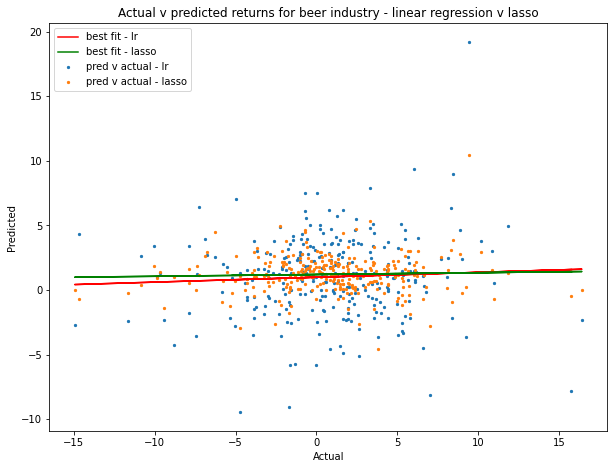

LR MSE: 27.673097360524462
Lasso MSE: 21.2648286496754


In [5]:
plt.rcParams["figure.figsize"] = (10,7.5)

# Create train and test subsets of the data (75%/25%)
train_set = round(len(df.iloc[:,30:])*.75)
Xr_train = (df.iloc[:train_set,30:])
Yr_train = df.iloc[:train_set,1]
Xr_test = (df.iloc[train_set:,30:])
Yr_test = df.iloc[train_set:,1]

# Forecast this month's industry returns for the beer industry using last month's 
# returns from all 30 industries using a simple linear regression.
lr1 = LinearRegression()
lr1.fit(Xr_train,Yr_train)
pred1 = lr1.predict(Xr_test)

# Forecast this month's industry returns for the beer industry using last month's 
# returns from all 30 industries using lasso regression.
lasso = Lasso(alpha=1.5)
lasso.fit(Xr_train,  Yr_train)
pred2 = lasso.predict(Xr_test)

# Plot line of best fit for LR prediction
a1, b1 = np.polyfit(Yr_test, pred1, 1)
plt.plot(Yr_test, a1*Yr_test+b1,c="Red", label='best fit - lr')     
# Plot predicted returns using LR v actual returns
plt.scatter(Yr_test,pred1,s=5, label='pred v actual - lr')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title("Actual v predicted returns for beer industry - linear regression v lasso")

# Plot line of best fit for lasso prediction
a2, b2 = np.polyfit(Yr_test, pred2, 1)
plt.plot(Yr_test, a2*Yr_test+b2,c="Green", label='best fit - lasso')     
# Plot predicted returns using lasso regression v actual returns
plt.scatter(Yr_test,pred2,s=5, label='pred v actual - lasso')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.legend()
plt.show()

# Print the MSE for both models
print("LR MSE:", mean_squared_error(Yr_test, pred1))
print("Lasso MSE:", mean_squared_error(Yr_test, pred2))

We can see from the two lines of best fit are basically the same between the two models, which is telling us how correlated the predicted and actual returns are (we would practically want this to line to have a slope of 1, perfectly correlated). 

However, we can also see the linear regression model has a higher variance (seen visually above) and might be overfitting on the training data. This is intuitive because we are training on 30 features.

Finally, the bias-variance trade-off is better in the lasso regression, as seen in the lower mean squared error.

### Analysis across all industries

Again, I will begin the analysis with indentify a reasonable alpha that can be used for all industries for the same reason as above.

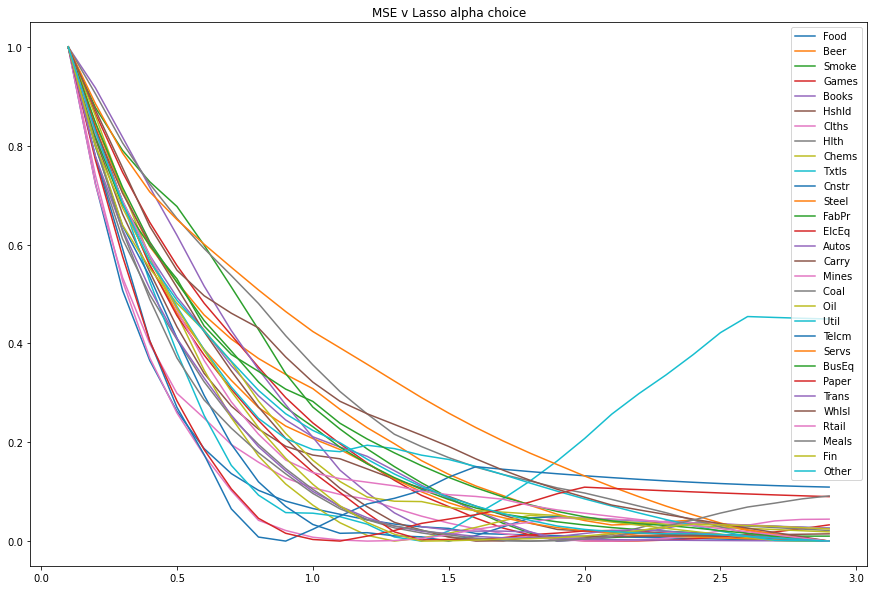

In [6]:
# Use Lasso at various alphas to see MSE

alphas = np.arange(.1, 3, .1)
plt.rcParams["figure.figsize"] = (15,10)

Xa_train = df.values[:train_set,30:]
Xa_test = df.values[train_set:,30:]
    
for j in range(0,30):
    
    MSE_lasso = list()
    Ya_train = df.values[:train_set,j]
    Ya_test = df.values[train_set:,j]
    
    for i in alphas:
        lasso = Lasso(alpha=i)
        lasso.fit(Xa_train,  Ya_train)
        pred2 = lasso.predict(Xa_test)
        MSE_lasso.append(mean_squared_error(Ya_test, pred2))
        
    MSE_minmax = preprocessing.minmax_scale(MSE_lasso, feature_range=(0, 1), axis=0, copy=True)
    plt.plot(alphas, MSE_minmax, label=df.columns[j])
    plt.title("MSE v Lasso alpha choice")
plt.legend()
plt.show()

Picking an alpha of 1.5 seems reasonable again for the rest of the industries

In [7]:
Xr_test = df.iloc[train_set:,30:]
Xr_train = df.iloc[:train_set,30:]

lr_mse = list()
lasso_coef = list()
lasso_mse = list()

for i in range(30):     

    Yr_test = df.iloc[train_set:,i]
    Yr_train = df.iloc[:train_set,i]
    
    # Forecast this month's industry returns using last month's 
    # returns from all 30 industries using a simple linear regression.
    
    lr1 = LinearRegression()
    lr1.fit(Xr_train,Yr_train)
    pred3 = lr1.predict(Xr_test)
    lr_mse.append(mean_squared_error(Yr_test, pred3))
    
    # Forecast this month's industry returns using last month's 
    # returns from all 30 industries using a lasso regression with alpha=1.5.    
   
    lasso = Lasso(alpha=1.5)
    lasso.fit(Xr_train,  Yr_train)
    pred4 = lasso.predict(Xr_test)
    lasso_coef.append(lasso.coef_)
    lasso_mse.append(mean_squared_error(Yr_test, pred4))


In [8]:
# Output the MSE by industry for both LR and lasso regression
result_df = pd.DataFrame({'industry': df.columns[:30].to_list(), 'lr_MSE': lr_mse,
                          'lasso_MSE':lasso_mse})
result_df["lr_MSE-lasso_MSE"] = result_df["lr_MSE"] - result_df["lasso_MSE"]
result_df

,industry,lr_MSE,lasso_MSE,lr_MSE-lasso_MSE
0,Food,17.704201,14.430887,3.273314
1,Beer,27.673097,21.264829,6.408269
2,Smoke,48.692697,46.146304,2.546393
3,Games,63.865788,56.891273,6.974514
4,Books,45.019405,41.843484,3.175921
5,Hshld,20.469077,17.888589,2.580487
6,Clths,46.068891,42.025196,4.043695
7,Hlth,20.154488,17.305883,2.848605
8,Chems,41.356268,38.226675,3.129594
9,Txtls,83.699903,80.605670,3.094233


To conclude, for lagged industry returns, we can see that using lasso regression produces predictions with lower MSE than using a linear regression across all 30 features, which runs a risk of high variance and overfitting. 

# Problem 2

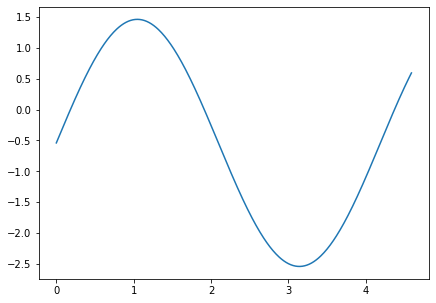

In [9]:
plt.rcParams["figure.figsize"] = (7,5)

e = np.random.normal(0, 1)
x = np.arange(0, 4.6,.01)
y = 2*np.sin(3*x/2) + e
plt.plot(x, y)
plt.show()

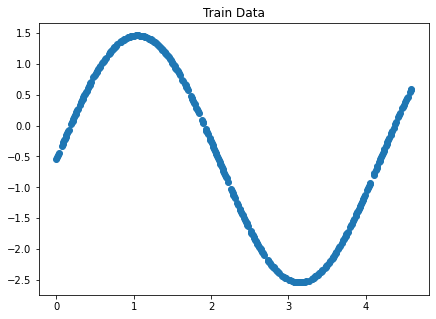

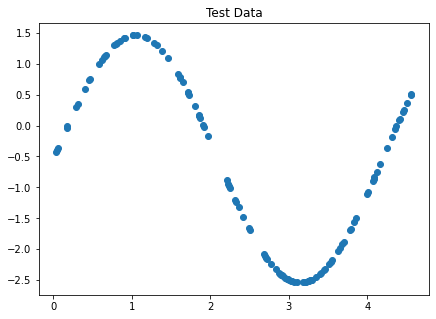

In [10]:
# Create features x, x^2, ..., x^9
output = pd.DataFrame()
output["y"] = y
features = pd.DataFrame()
for i in range(1,10):
    features["x^"+str(i)] = pow(x,i)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, output, test_size=0.25, random_state=1)
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

# Plot what the train data and test data looks like
plt.scatter(X_train.values[:,0],y_train)
plt.title("Train Data")
plt.show()
plt.scatter(X_test.values[:,0],y_test)
plt.title("Test Data")
plt.show()


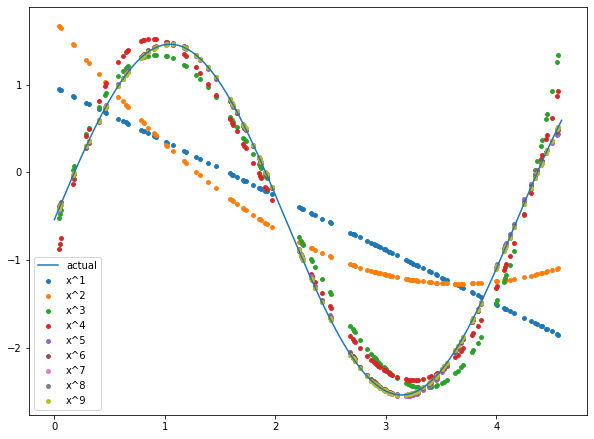

In [11]:
# Regression predicting y 
# using {x}, {x, x^2}, {x, x^2, x^3}, ... as features
plt.rcParams["figure.figsize"] = (10,7.5)

for i in range(1,10): 
    Xp2_train = X_train.iloc[:,0:i]
    Xp2_test = X_test.iloc[:,0:i]
    lrp2 = LinearRegression()
    lrp2.fit(Xp2_train,y_train)
    pred_test = lrp2.predict(Xp2_test)
    xi = X_test["x^1"]
    plt.scatter(xi,pred_test, label="x^"+str(i), s=15)
    plt.legend()
plt.plot(x,y, label="actual")
plt.legend()
plt.show()

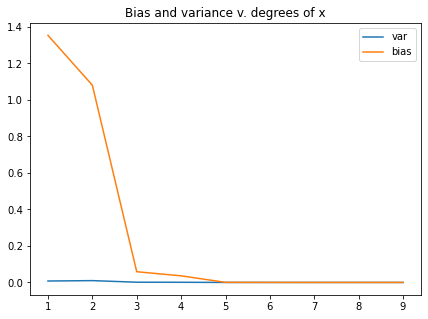

var: [0.007839260453685368, 0.009976429087970381, 0.0012549030727417572, 0.0009503619877777968, 2.010049961725562e-05, 1.0602221251217257e-05, 9.176185075014717e-08, 3.5336206247545676e-08, 1.1467552036809943e-10]
bias: [1.3537216441245357, 1.0808302699300627, 0.05878458353198182, 0.036209232547371004, 0.0005366872366028534, 0.00021194412583257465, 1.6207602826446704e-06, 3.9891361054668627e-07, 1.8810045806387465e-09]


In [12]:
# Get the MSE, bias, and variance using bias_variance_decomp
mse_list = list()
bias_list = list()
var_list = list()

for i in range(1,10): 
    Xp2_train = X_train.iloc[:,0:i].sort_index()
    Xp2_test = X_test.iloc[:,0:i].sort_index()
    lrp2 = LinearRegression()
    
    mse, bias, var = bias_variance_decomp(lrp2, Xp2_train.values, y_train.iloc[:,0].values, 
                                          Xp2_test.values, y_test.iloc[:,0].values, loss="mse")
    
    mse_list.append(mse)
    bias_list.append(bias)
    var_list.append(var)

plt.rcParams["figure.figsize"] = (7,5)
plt.plot(np.arange(1, 10, 1),var_list, label="var")

plt.plot(np.arange(1, 10, 1),bias_list, label="bias")
plt.title("Bias and variance v. degrees of x")
plt.legend()
plt.show()
print("var:", var_list)
print("bias:",bias_list)